In [1]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_predict
from matplotlib import pyplot as plt
from skimage import img_as_float, util
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import skimage.io as io
import numpy as np
import cv2

# Wstępne przetworzenie obrazu i wczytanie benchmarku 

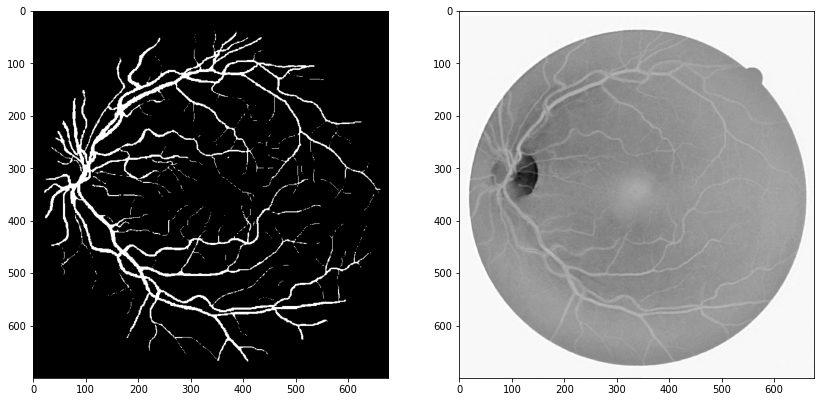

In [2]:
idx = 1
img = img_as_float(io.imread(f'test_res/test{idx}.jpg'))
img = img[:, :, 1]
img = rescale(img, 1, anti_aliasing=False)
img = util.invert(img)

good = img_as_float(io.imread(f'test_res/res{idx}.jpg'))[:, :, 1]
i = 0
while i < len(good):
    j = 0
    while j < len(good[i]):
        if good[i][j] > 0.9:
            good[i][j] = 1
        else:
            good[i][j] = 0
        j += 1
    i += 1

fig, axs = plt.subplots(1, 2)
axs[0].imshow(good, cmap="gray")
axs[1].imshow(img, cmap="gray")
fig.set_size_inches(14, 10)
plt.show()

# Podzielenie obrazu na fragmenty 5 x 5

In [3]:
h, w = img.shape
new_img = np.zeros((h - 4, w - 4, 5, 5))
benchmark = np.zeros((h - 4, w - 4))
for i in range(2, h - 4):
    for j in range(2, w - 4):
        benchmark[i - 2][j - 2] = good[i][j]
        new_img[i][j] = [
            [img[i - 2][j - 2], img[i - 2][j - 1], img[i - 2][j], img[i - 2][j + 1], img[i - 2][j + 2]],
            [img[i - 1][j - 2], img[i - 1][j - 1], img[i - 1][j], img[i - 1][j + 1], img[i - 1][j + 2]],
            [img[i][j - 2], img[i][j - 1], img[i][j], img[i][j + 1], img[i][j + 2]],
            [img[i + 1][j - 2], img[i + 1][j - 1], img[i + 1][j], img[i + 1][j + 1], img[i + 1][j + 2]],
            [img[i + 2][j - 2], img[i + 2][j - 1], img[i + 2][j], img[i + 2][j + 1], img[i + 2][j + 2]],
        ]

# Obliczenie parametrów każdego z fragmentów

In [4]:
main_data = []
for i in new_img:
    cur_row = []
    for j in i:
        this_fragment = []
        moments = cv2.moments(j)
        huMoments = cv2.HuMoments(moments)
        variance = np.var(j)
        this_fragment = [
            moments['mu20'],
            moments['mu11'],
            moments['mu02'],
            moments['mu30'],
            moments['mu21'],
            moments['mu12'],
            moments['mu03']] + [
            huMoments[0][0],
            huMoments[1][0],
            huMoments[2][0],
            huMoments[3][0],
            huMoments[4][0],
            huMoments[5][0],
            huMoments[6][0],
            variance]
        main_data.append(this_fragment)

In [5]:
target = np.zeros((len(benchmark) * len(benchmark[0])))
k = 0
for i in benchmark:
    for j in i:
        target[k] = j
        k += 1

# Hold out test

In [6]:
X = main_data
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"true positives = {tp}")
print(f"true negatives = {tn}")
print(f"false positives = {fp}")
print(f"false negatives = {fn}")
print(f"accuracy = {(tn + tp)/(tn + tp + fn + fp)}")
print(f"sensitivity = {tp/(tp + fn)}")
print(f"specificity = {tn/(tn + fp)}")

true positives = 3696
true negatives = 85041
false positives = 2161
false negatives = 2784
accuracy = 0.947215046647168
sensitivity = 0.5703703703703704
specificity = 0.975218458292241


# Cross-validation prediction

In [ ]:
y_pred = cross_val_predict(knn, X, y, cv=5)

In [ ]:
res = np.zeros((h - 4, w - 4))
i = 0
j = 0
k = 0
while i < benchmark.shape[0]:
    j = 0
    while j < benchmark.shape[1]:
        res[i][j] = y_pred[k]
        k += 1
        j += 1
    i += 1

In [ ]:
plt.imshow(res, cmap="gray")